In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import glob
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:

# -------------------------------
# DATASET
# -------------------------------
class NCIDataset(Dataset):
    def __init__(self, df, density_dir, descriptor_cols, label_col="target_nci", scaler=None):
        self.df = df.reset_index(drop=True)
        self.density_dir = density_dir
        self.descriptor_cols = descriptor_cols
        self.label_col = label_col

        # Normalize descriptors
        if scaler == None:
            self.scaler = StandardScaler()
        else:
            self.scaler = scaler
        self.descriptors = self.scaler.fit_transform(df[descriptor_cols].values)
        self.labels = df[label_col].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        density_path = os.path.join(self.density_dir, row["molecule_name"] + ".npy")
        density = np.load(density_path).astype(np.float32)
        density = np.expand_dims(density, axis=0)  # (1, D, H, W)
        desc = self.descriptors[idx].astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(density), torch.tensor(desc), torch.tensor(label)

# -------------------------------
# MODELS
# -------------------------------
class EDNCI(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.dropout = nn.Dropout3d(0.3)
        # After two pools: (137→68→34, 133→66→33, 124→62→31) → ~34*33*31*64 ≈ 2.2M
        self.fc = nn.Linear(64 * 34 * 33 * 31, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        return x

class CPNCI(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 10)

    def forward(self, x):
        return torch.relu(self.fc(x))

class DeepNCI(nn.Module):
    def __init__(self, desc_dim):
        super().__init__()
        self.ednci = EDNCI()
        self.cpnci = CPNCI(desc_dim)
        self.fusion = nn.Sequential(
            nn.Linear(128 + 10, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # regression output
        )

    def forward(self, density, descriptors):
        f1 = self.ednci(density)
        f2 = self.cpnci(descriptors)
        fused = torch.cat([f1, f2], dim=1)
        out = self.fusion(fused)
        return out.squeeze(-1)


In [3]:
BATCH_SIZE = 2
LEARNING_RATE = 1e-4
EPOCHS = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sesuaikan path
DENSITY_NPY_DIR = "./density_npy"
DESCRIPTORS_CSV = "./molecular_properties_results.csv"  # Kolom: filename (tanpa .npy), dft_nci, prop1, prop2, ..., target_nci
TARGET_NCI = "./target.csv"
TARGET_GRID = (137, 133, 124)

In [4]:

# Load descriptor + label data
df = pd.read_csv(DESCRIPTORS_CSV)
df.head()

,total_energy,homo_energy,lumo_energy,homo_minus_1,lumo_plus_1,homo_lumo_gap,potential_energy,kinetic_energy,correlation_energy,exchange_energy,...,gibbs_free_energy,dipole_x,dipole_y,dipole_z,quadrupole_xx,quadrupole_yy,quadrupole_zz,electronic_spatial_extent,molecule_name,num_atoms
0,-113.034335,0.0,0.0,0.0,0.0,0.0,-79.124034,-33.910300,-11.303433,-22.606867,...,-113.034335,2.220446e-16,0.000000e+00,0.0,0.0,0.0,0.0,4.440892e-16,1155_ammoniadimer09,9
1,-113.034330,0.0,0.0,0.0,0.0,0.0,-79.124031,-33.910299,-11.303433,-22.606866,...,-113.034330,-3.552714e-15,1.110223e-16,0.0,0.0,0.0,0.0,7.108896e-15,1156_ammoniadimer10,9
2,-113.031232,0.0,0.0,0.0,0.0,0.0,-79.121862,-33.909370,-11.303123,-22.606246,...,-113.031232,2.220446e-16,-3.552714e-15,0.0,0.0,0.0,0.0,7.119292e-15,1157_ammoniadimer12,9
3,-113.028057,0.0,0.0,0.0,0.0,0.0,-79.119640,-33.908417,-11.302806,-22.605611,...,-113.028057,6.661338e-16,8.881784e-16,0.0,0.0,0.0,0.0,2.220446e-15,1158_ammoniadimer15,9
4,-113.026393,0.0,0.0,0.0,0.0,0.0,-79.118475,-33.907918,-11.302639,-22.605279,...,-113.026393,6.661338e-16,1.776357e-15,0.0,0.0,0.0,0.0,3.794300e-15,1159_ammoniadimer20,9


In [5]:
target = pd.read_csv(TARGET_NCI)
target.head()

,code,ccbd
0,1155,-15.13
1,1156,-16.70
2,1157,-13.93
3,1158,-8.18
4,1159,-3.26


In [6]:
X = df.drop(['num_atoms'], axis=1) # axis=1 specifies dropping a column
Y = target.drop(target.columns[0], axis=1)

In [7]:
data = pd.concat([X, Y], axis=1)
data.head()

,total_energy,homo_energy,lumo_energy,homo_minus_1,lumo_plus_1,homo_lumo_gap,potential_energy,kinetic_energy,correlation_energy,exchange_energy,...,gibbs_free_energy,dipole_x,dipole_y,dipole_z,quadrupole_xx,quadrupole_yy,quadrupole_zz,electronic_spatial_extent,molecule_name,ccbd
0,-113.034335,0.0,0.0,0.0,0.0,0.0,-79.124034,-33.910300,-11.303433,-22.606867,...,-113.034335,2.220446e-16,0.000000e+00,0.0,0.0,0.0,0.0,4.440892e-16,1155_ammoniadimer09,-15.13
1,-113.034330,0.0,0.0,0.0,0.0,0.0,-79.124031,-33.910299,-11.303433,-22.606866,...,-113.034330,-3.552714e-15,1.110223e-16,0.0,0.0,0.0,0.0,7.108896e-15,1156_ammoniadimer10,-16.70
2,-113.031232,0.0,0.0,0.0,0.0,0.0,-79.121862,-33.909370,-11.303123,-22.606246,...,-113.031232,2.220446e-16,-3.552714e-15,0.0,0.0,0.0,0.0,7.119292e-15,1157_ammoniadimer12,-13.93
3,-113.028057,0.0,0.0,0.0,0.0,0.0,-79.119640,-33.908417,-11.302806,-22.605611,...,-113.028057,6.661338e-16,8.881784e-16,0.0,0.0,0.0,0.0,2.220446e-15,1158_ammoniadimer15,-8.18
4,-113.026393,0.0,0.0,0.0,0.0,0.0,-79.118475,-33.907918,-11.302639,-22.605279,...,-113.026393,6.661338e-16,1.776357e-15,0.0,0.0,0.0,0.0,3.794300e-15,1159_ammoniadimer20,-3.26


In [8]:
# Assume df has column 'filename' matching .npy names (without extension)
# Descriptor columns (exclude filename, target_nci, but include DFT NCI as primary descriptor!)
DESC_COLS = [col for col in data.columns if col not in ["molecule_name", "ccbd"]]
DESC_COLS
# Ensure 'dft_nci' is included — it's critical per paper

# Split train/val/test (80/10/10)
#train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
#val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
train, test = train_test_split(data, test_size=0.3, random_state=42)

train_dataset = NCIDataset(train, DENSITY_NPY_DIR, DESC_COLS, label_col="ccbd")
test_dataset = NCIDataset(test, DENSITY_NPY_DIR, DESC_COLS, label_col="ccbd", scaler=train_dataset.scaler)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
model = DeepNCI(desc_dim=len(DESC_COLS)).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

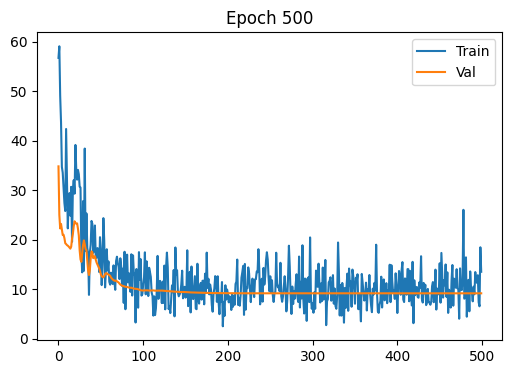

Epoch 500/500 | Train Loss: 13.548638 | Val Loss: 9.199984
Training selesai. Model terbaik disimpan sebagai 'best_deepnci.pth'
Elapsed time: 4751.979640 seconds


In [33]:


start_time = time.perf_counter()


plt.ion()
fig, ax = plt.subplots()
line1, = ax.plot([], [], 'r-', label='Train')
line2, = ax.plot([], [], 'b-', label='Val')
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
plt.show()

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for density, desc, target in train_loader:
        density, desc, target = density.to(DEVICE), desc.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(density, desc)
            loss = criterion(pred, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # loss.backward()
        # optimizer.step()
        train_loss += loss.item()
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for density, desc, target in test_loader:
            density, desc, target = density.to(DEVICE), desc.to(DEVICE), target.to(DEVICE)
            pred = model(density, desc)
            val_loss += criterion(pred, target).item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.title(f'Epoch {epoch+1}')
    plt.show()
    time.sleep(0.1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_deepnci.pth")
        print(" → Saved best model")

    torch.cuda.empty_cache()
print("Training selesai. Model terbaik disimpan sebagai 'best_deepnci.pth'")

end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")

In [17]:
model.load_state_dict(torch.load("best_deepnci.pth"))
model.eval()

all_targets = []
all_preds = []

with torch.no_grad():
    for density, desc, target in test_loader:
        density, desc, target = density.to(DEVICE), desc.to(DEVICE), target.to(DEVICE)
        pred = model(density, desc)
        all_targets.extend(target.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())

all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Metrik regresi
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n=== EVALUASI AKHIR (Test Set) ===")
print(f"RMSE: {rmse:.4f} kcal/mol")
print(f"MAE : {mae:.4f} kcal/mol")
print(f"R²  : {r2:.4f}")



=== EVALUASI AKHIR (Test Set) ===
RMSE: 3.1292 kcal/mol
MAE : 2.7431 kcal/mol
R²  : 0.5867


In [37]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    print(f"{'Total parameters':<25}: {total_params:,}")
    print(f"{'Trainable parameters':<25}: {trainable_params:,}")
    print(f"{'Non-trainable parameters':<25}: {non_trainable_params:,}")
    return total_params, trainable_params

# Panggil setelah model dibuat
print("=== MODEL PARAMETER COUNT ===")
count_parameters(model)

=== MODEL PARAMETER COUNT ===
Total parameters         : 285,001,757
Trainable parameters     : 285,001,757
Non-trainable parameters : 0


(285001757, 285001757)

In [40]:
from torchinfo import summary

# Pastikan Anda menginstal torchinfo: pip install torchinfo
print("\n=== MODEL ARCHITECTURE SUMMARY ===")
summary(
    model,
    input_data=[
        torch.randn(1, 1, 137, 133, 124),  # density cube batch
        torch.randn(1, len(DESC_COLS))      # descriptor vector
    ],
    device=DEVICE,
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=5
)


=== MODEL ARCHITECTURE SUMMARY ===


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DeepNCI                                  [1, 1, 137, 133, 124]     [1]                       --                        --
├─EDNCI: 1-1                             [1, 1, 137, 133, 124]     [1, 128]                  --                        --
│    └─Conv3d: 2-1                       [1, 1, 137, 133, 124]     [1, 32, 137, 133, 124]    896                       [3, 3, 3]
│    └─MaxPool3d: 2-2                    [1, 32, 137, 133, 124]    [1, 32, 68, 66, 62]       --                        2
│    └─Conv3d: 2-3                       [1, 32, 68, 66, 62]       [1, 64, 68, 66, 62]       55,360                    [3, 3, 3]
│    └─MaxPool3d: 2-4                    [1, 64, 68, 66, 62]       [1, 64, 34, 33, 31]       --                        2
│    └─Dropout3d: 2-5                    [1, 64, 34, 33, 31]       [1, 64, 34, 33, 31]       --                        --
│ 